In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

- 군집 : 비슷한 샘플을 클러스터로 모읍니다. 군집은 데이터 분석, 고객 분류, 추천 시스템, 검색 엔진, 이미지 분할, 준지도 학습, 차원 축소 등에 사용할 수 있는 훌륭한 도구입니다.
- 이상치 탐지 : '정상' 데이터가 어떻게 보이는지를 학습합니다. 그 다음 비정상 샘플을 감지하는 데 사용합니다. 예를 들면 제조 라인에서 결함 제품을 감지하거나 시계열 데이터에서 새로운 트렌드를 찾습니다.
- 밀도 추정 : 데이터셋 생성 확률 과정의 확률 밀도 함수를 추정합니다. 밀도 추정은 이상치 탐지에 널리 사용됩니다. 밀도가 매우 낮은 영역에 놓인 샘플이 이상치일 가능성이 높습니다. 또한 데이터 분석과 시각화에도 유용합니다.

## 9.1 군집

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

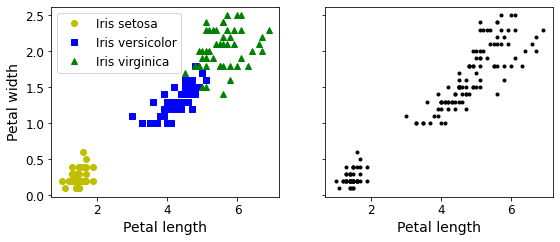

In [4]:
plt.figure(figsize=(9,3.5))

plt.subplot(121)
plt.plot(X[y==0,2], X[y==0,3], "yo", label="Iris setosa")
plt.plot(X[y==1,2], X[y==1,3], "bs", label="Iris versicolor")
plt.plot(X[y==2,2], X[y==2,3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width",fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:,2], X[:,3], c="k", marker=".")
plt.xlabel("Petal length")
plt.tick_params(labelleft=False)

plt.show()

- 고객 분류 : 고객을 구매 이력이나 웹사이트 내 행동 등을 기반으로 클러스터로 모을 수 있습니다. 이는 고객이 누구인지, 고객이 무엇을 원하는지 이해하는 데 도움이 됩니다. 고객 그룹마다 제품 추천이나 마케팅 전략을 다르게 적용할 수 있습니다. 예를 들어 동일한 클러스터 내의 사용자가 좋아하는 컨텐츠를 추천하는 추천 시스템을 만들 수 있습니다.

- 데이터 분석 : 새로운 데이터셋을 분석할 때 군집 알고리즘을 실행하고 각 클러스터를 따로 분석하면 도움이 됩니다.

- 차원 축소 기법 : 한 데이터셋에 군집 알고리즘을 적용하면 각 클러스터에 대한 샘플의 친화성을 측정할 수 있습니다. (친화성은 샘플이 클러스터에 얼마나 잘 맞는지를 측정합니다.) 각 샘플의 특성 벡터 x는 클러스터 친화성의 벡터로 바꿀 수 있습니다. k개의 클러스터가 있다면 이 벡터는 k차원이 됩니다. 이 벡터는 일반적으로 원본 특성 벡터보다 훨씬 저차원입니다. 하지만 이후 분석을 위한 충분한 정보를 가질 수 있습니다.

- 이상치 탐지 : 모든 클러스터에 친화성이 낮은 샘플은 이상치일 가능성이 높습니다. 웹사이트 내 행동을 기반으로 사용자의 클러스터를 만들었다면 초당 웹서버 요청을 비정상적으로 많이 하는 사용자를 감지할 수 있습니다. 이상치 탐지는 특히 제조 분야에서 결함을 감지할 때 유용합니다. 또는 부정 거래 감지에 활용됩니다.

- 준지도 학습 : 레이블된 샘플이 적다면 군집을 수행하고 동일한 클러스터에 있는 모든 샘플에 레이블을 전파할 수 있습니다. 이 기법은 이어지는 지도 학습 알고리즘에 필요한 레이블이 크게 증가해 성능을 크게 향상합니다.

- 검색 엔진 : 일부 검색 엔진은 제시된 이미지와 비슷한 이미지를 찾아줍니다. 이런 시스템을 구축하려면 먼저 데이터 베이스에 있는 모든 이미지에 군집 알고리즘을 적용해야 합니다. 비슷한 이미지는 동일한 클러스터에 속합니다. 사용자가 찾으려는 이미지를 제공하면 훈련된 군집 모델을 사용해 이미지의 클러스터를 찾습니다. 그 다음 이 클러스터의 모든 이미지를 반환합니다.

- 이미지 분할 : 색을 기반으로 픽셀을 클러스터로 모읍니다. 그 다음 각 픽셀의 색을 해당 클러스터의 평균 색으로 바꿉니다. 이는 이미지에 있는 색상의 종류를 크게 줄입니다. 이렇게 하면 물체의 윤곽을 감지하기 쉬워져 물체 탐지 및 추적 시스템에서 이미지 분할을 많이 활용합니다.

### 9.1.1 k- 평균

In [5]:
from sklearn.datasets import make_blobs

In [6]:
blob_centers = np.array([[0.2,2.3],
                        [-1.5,2.3],
                        [-2.8,1.8],
                        [-2.8,2.8],
                        [-2.8,1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

In [7]:
X, y = make_blobs(n_samples=2000, centers=blob_centers,
                 cluster_std=blob_std, random_state=7)

In [8]:
def plot_clusters(X,y=None):
    plt.scatter(X[:,0], X[:,1], c=y, s=1)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

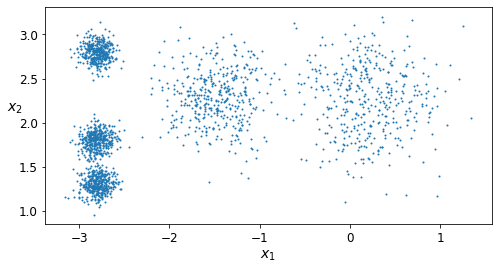

In [9]:
plt.figure(figsize=(8,4))
plot_clusters(X)
plt.show()

In [10]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [11]:
y_pred

array([4, 0, 1, ..., 2, 1, 0])

In [12]:
y_pred is kmeans.labels_

True

In [13]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

In [14]:
X_new = np.array([[0,2],[3,2],[-3,3],[-3,2.5]])
kmeans.predict(X_new)

array([1, 1, 2, 2])

In [15]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12, 
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

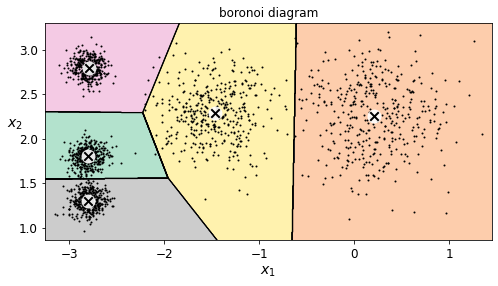

In [16]:
plt.figure(figsize=(8,4))
plot_decision_boundaries(kmeans, X)
plt.title("boronoi diagram")
plt.show()

하드 군집 vs 소프트 군집

하드 군집 : 샘플을 하나의 클러스터에 할당, 샘플에 대해 가장 가까운 클러스터를 선택
소프트 군집 : 클러스터마다 샘플에 점수를 부여

transform() : 샘플과 각 센트로이드 사이의 거리를 반환

In [17]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

k-평균 알고리즘 : 가장 빠르고 가장 간단한 군집 알고리즘
- 먼저 k개의 센트로이드를 랜덤하게 초기화 : 데이터셋에서 k개의 샘플을 랜덤하게 선택하고 센트로이드를 그 위치에 놓습니다.
- 수렴할 때까지 다음을 반복합니다.(즉, 센트로이드가 더이상 이동하지 않을 때까지):
1. 각 샘플을 가장 가까운 센트로이드에 할당합니다.
2. 센트로이드에 할당된 샘플의 평균으로 센트로이드를 업데이트합니다.

kmeans 클래스는 기본적으로 최적화된 알고리즘을 적용합니다. 교육적인 목적으로 원래 k-평균 알고리즘을 사용하려면 init="randome", n_init=1, algorithm="full"로 설정해야합니다. 이 매개변수들은 아래에서 설명하겠습니다.

In [18]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                      algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

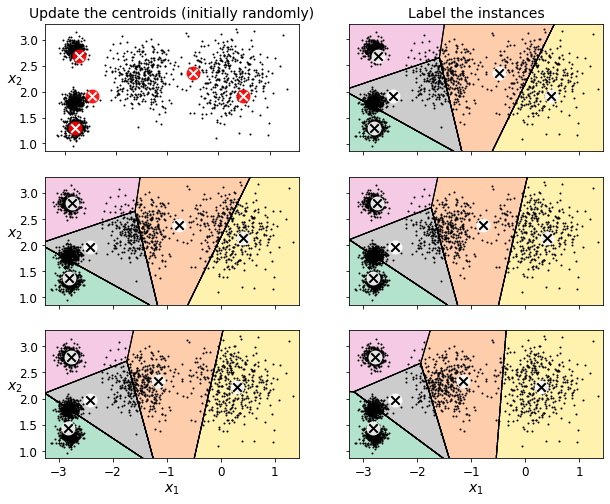

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

k-평균의 변동성

원래 k-평균 알고리즘에서는 센트로이드가 그냥 랜덤하게 초기되고 알고리즘은 단순히 한 번씩 반복하여 앞서 본 것처럼 점차 센트로이드를 개선시킨다. 하지만 이 방식의 문제점은 k-평균을 여러번 (또는 다른 랜덤 시드로) 실행하면 아래에서 보듯 매우 다른 결과를 얻게 됩니다.

In [20]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


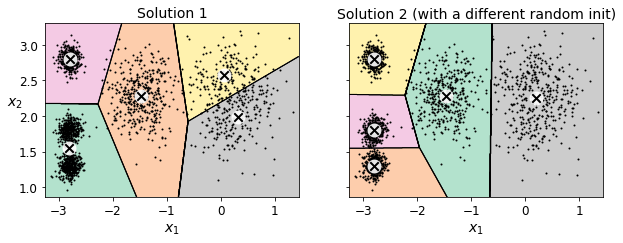

In [21]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                          algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

plt.show()

이니셔 : 각 샘플과 가장 가까운 센트로이드 사이의 평균 제곱 거리

In [22]:
kmeans.inertia_

211.59853725816836

이니셔는 각 훈련 샘플과 가장 가까운 센트로이드 사이의 제곱 거리의 합으로 쉽게 검증할 수 있다.

In [23]:
X_dist = kmeans.transform(X)
np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)

211.59853725816856

score() 메서드는 이니셔의 음숫값을 반환한다. 예측기의 score() 메서드는 사이킷런의 '큰 값이 좋은 것이다' 라는 규칙을 따르기 때문

In [24]:
kmeans.score(X)

-211.59853725816836

k-평균 속도 개선과 미니배치 k-평균

미니배치 k-means는 속도가 더 빠르다

In [25]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5)
minibatch_kmeans.fit(X)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 4096 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(n_clusters=5)

센트로이드 초기화 방법

In [26]:
KMeans()

KMeans()

In [27]:
good_init = np.array([[-3,3],[-3,2],[-3,1],[-1,2],[0,2]])
kmeans = KMeans(n_clusters=5, init = good_init, n_init=1,random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.59853725816836

최적의 클러스터 개수 찾기

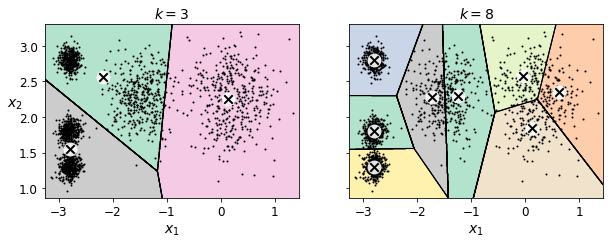

In [28]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8,X, "$k=3$", "$k=8$")
plt.show()

In [29]:
kmeans_k3.inertia_

653.2167190021553

In [30]:
kmeans_k8.inertia_

119.11983416102882

이니셔는 k가 증가함에 따라 점점 작아지믈 k를 선택할 때 좋은 성능 지표가 아닙니다. 실제로 클러스터가 늘어날수록 각 샘플은 가까운 센트로이드에 더 가깝게 됩니다. 따라서 이니셔는 더 작아질 것입니다. 이니셔를 k의 함수로 그래프를 그려보겠습니다.

In [31]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
               for k in range(1,10)]
inertias = [model.inertia_ for model in kmeans_per_k]

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


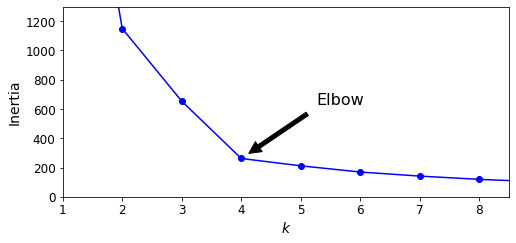

In [32]:
plt.figure(figsize=(8,3.5))
plt.plot(range(1,10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate("Elbow",
            xy=(4, inertias[3]),
            xytext=(0.55,0.55),
            textcoords='figure fraction',
            fontsize=16,
            arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1,8.5,0,1300])
plt.show()

실루엣 점수 : 실루엣 계수의 평균

실루엣 계수 = (b-a)/max(a,b)
a : 동일한 클러스터에 있는 다른 샘플까지 평균거리 (클러스터 내부의 평균거리)
b : 가장 가까운 클러스터까지 평균 거리 (가장 가까운 클러스터의 샘플까지 평균 거리, 샘플과 가장 가까운 클러스터는 자신이 속한 클러스터는 제외하고 b가 최소인 클러스터)

실루엣 계수는 -1과 1 사이의 값을 가진다. 1에 가까울 수록 자신의 클러스터 안에 잘 속해 있고 다른 클러스터와는 멀리 떨어져있다는 뜻이다.
0에 가까우면 클러스터의 경계에, -1에 가까우면 샘플이 잘못된 클러스터에 할당되었다는 의미.

In [33]:
from sklearn.metrics import silhouette_score

In [34]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [35]:
silhouette_scores = [silhouette_score(X, model.labels_)
                    for model in kmeans_per_k[1:]]

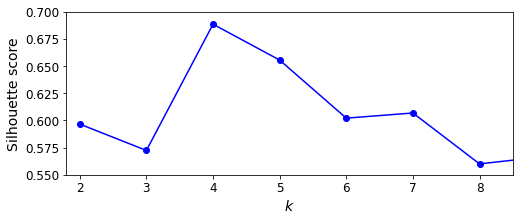

In [36]:
plt.figure(figsize=(8,3))
plt.plot(range(2,10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8,8.5,0.55,0.7])
plt.show()

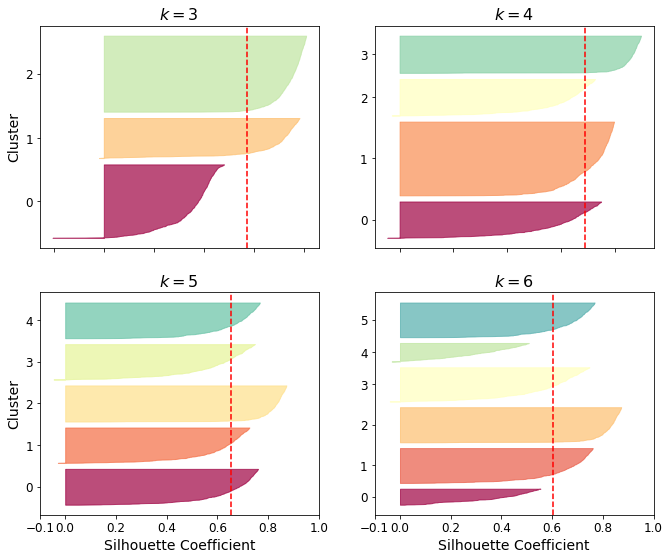

In [37]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

plt.show()

### 9.1.3 군집을 사용한 이미지 분할

In [38]:
# 무당벌레 이미지를 다운로드합니다
import urllib

images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
filename = "ladybug.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\unsupervised_learning\\ladybug.png',
 <http.client.HTTPMessage at 0x2880f20c790>)

In [39]:
from matplotlib.image import imread #or 'from imagei import imread'
image = imread(os.path.join("images", "unsupervised_learning", "ladybug.png"))
image.shape

(533, 800, 3)

In [40]:
X = image.reshape(-1,3)
kmeans = KMeans(n_clusters=8).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

In [41]:
segmented_imgs = []
n_colors = (10,8,6,4,2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

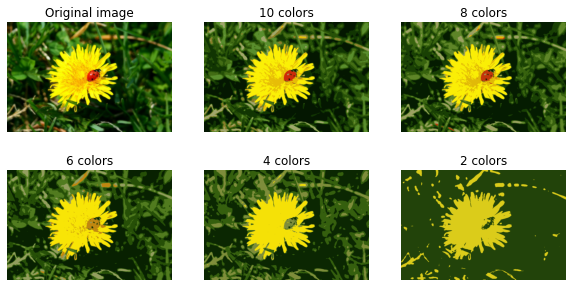

In [42]:
plt.figure(figsize=(10,5))
n_colors = (10,8,6,4,2)
plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis("off")
plt.show()

### 9.1.4 군집을 사용한 전처리

In [43]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y = True)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

In [45]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class ="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [46]:
log_reg_score = log_reg.score(X_test,y_test)
log_reg_score

0.9688888888888889

기준값으로 96.9% 정확도를 얻었습니다.
k-평균을 전처리 단계로 사용해 더 좋아지는지 확인하기 위해 파이프라인을 만들어 먼저 훈련 세트를 50개의 클러스터로 모듭니다.
그런 다음 이미지를 50개 클러스터까지 거리로 바꿉니다. 그 다음 로지스틱 회귀 모델을 적용합니다.

In [47]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class ="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])
pipeline.fit(X_train, y_train)    

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

In [48]:
pipeline_score = pipeline.score(X_test,y_test)
pipeline_score

0.9777777777777777

In [49]:
1 - (1 - pipeline_score) / (1 - log_reg_score)

0.28571428571428414

오차율을 약 35%까지 줄였습니다.

In [50]:
from sklearn.model_selection import GridSearchCV

param_grid = dict(kmeans__n_clusters=range(2,100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=2; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=3; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=4; total time=   0.2s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.3s
[CV] END ...............................kmeans__n_clusters=5; total time=   0.4s
[CV] END ...............................kmeans_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

In [51]:
grid_clf.best_params_

{'kmeans__n_clusters': 95}

In [52]:
grid_clf.score(X_test,y_test)

0.9777777777777777

### 9.1.5 군집을 사용한 준지도 학습
레이블이 없는 데이터가 많고 레이블이 있는 데이터는 적을 때 사용한다.

In [53]:
n_labeled = 50
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(multi_class='ovr', random_state=42)

In [54]:
log_reg.score(X_test,y_test)

0.8333333333333334

센트로이드에서 가장 가까운 이미지를 찾습니다. 즉 대표 이미지

In [59]:
k = 50
kmeans = KMeans(n_clusters=k)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis = 0)
X_representative_digits = X_train[representative_digit_idx]

대표 이미지를 출력하고 수동으로 레이블을 할당하기

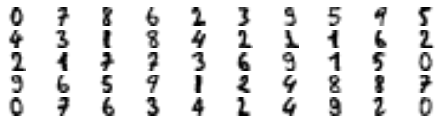

In [62]:
plt.figure(figsize=(8,2))
for index,X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k//10,10, index + 1)
    plt.imshow(X_representative_digit.reshape(8,8), cmap="binary", interpolation="bilinear")
    plt.axis("off")
    
plt.show()

In [63]:
y_train[representative_digit_idx]

array([0, 7, 8, 6, 2, 3, 9, 5, 9, 5, 4, 3, 1, 8, 4, 2, 1, 1, 6, 2, 2, 1,
       7, 7, 3, 6, 9, 1, 5, 0, 9, 6, 5, 9, 1, 2, 4, 8, 8, 7, 0, 7, 6, 3,
       4, 2, 4, 9, 2, 0])

In [64]:
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 7, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9])

무작위로 고른 샘플이 아니고 이 이미지들은 각 클러스터를 대표하는 이미지입니다. 성능이 조금이라도 높은지 확인하기

In [65]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.09333333333333334

샘플에 레이블을 부여한느 것은 비용이 많이 들고 어렵습니다. 특히 전문가가 수동으로 처리해야할 때 그렇습니다.
따라서 무작위 샘플 대신 대표 샘플에 레이블을 할당하는 것이 좋은 방법이다.
이 레이블을 동일한 클러스터에 있는 모든 샘플로 전파하는 것은 어떨까요? (레이블 전파)

In [66]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [67]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)
log_reg.score(X_test, y_test)

0.13111111111111112

아주 약간의 성능을 올렸다. 문제는 각 대표 샘플의 레이블을 동일한 클러스터의 모든 샘플에 전파한 것이다. 여기에는 클러스터 경계에 가깝게 위치한 샘플이 포함되어 있고 아마 잘못 레이블이 부여되었을 것이다. 센트로이드와 가까운 샘플의 75번째 백분위수까지만 레이블을 전파해보고 어떻게 되는지 확인해보겠습니다.

In [74]:
percentile_closest = 75

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [75]:
log_reg = LogisticRegression(multi_class = "ovr", solver = "lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)
log_reg.score(X_test, y_test)

0.11777777777777777

In [77]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.14257228315054835

### 9.1.6 DBSCAN
모든 클러스터가 충분히 밀집되어 있고 밀집되지 않은 지역과 잘 구분될 때 좋은 성능을 나타낸다.

In [114]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=1000, noise=0.05)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [115]:
dbscan.labels_[:10]

array([0, 1, 2, 3, 4, 0, 0, 0, 0, 4], dtype=int64)

-1 레이블은 알고리즘이 이 샘플을 이상치로 판단했다는 의미이다.

In [116]:
len(dbscan.core_sample_indices_)

808

In [119]:
dbscan.core_sample_indices_[:10]

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10], dtype=int64)

In [120]:
dbscan.components_

array([[-0.55720278,  0.8644788 ],
       [ 0.90389926,  0.32457175],
       [ 0.31276183, -0.17563033],
       ...,
       [ 1.91635123,  0.33863991],
       [ 1.03705393, -0.53795404],
       [-0.96668713,  0.12385321]])

In [121]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [122]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [123]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

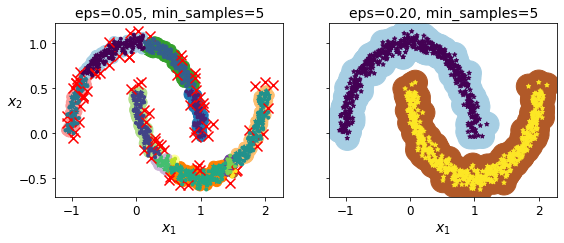

In [125]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

In [126]:
dbscan = dbscan2

In [131]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [134]:
X_new = np.array([[-0.5,0],[0,0.5],[1,-0.1],[2,1]])
knn.predict(X_new)

array([0, 1, 0, 1], dtype=int64)

In [133]:
knn.predict_proba(X_new)

array([[0.8, 0.2],
       [0. , 1. ],
       [0.8, 0.2],
       [0. , 1. ]])

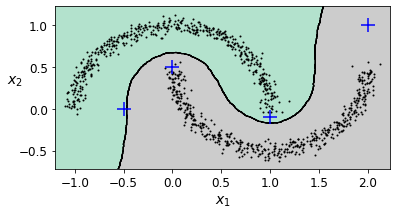

In [141]:
plt.figure(figsize=(6,3))
plot_decision_boundaries(knn, X , show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:,1], c="b",marker="+", s=200, zorder=10)
plt.show()

In [142]:
y_dist,y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  1,  0, -1], dtype=int64)

### 9.1.7 다른 군집 알고리즘
스펙트럼 군집

In [143]:
from sklearn.cluster import SpectralClustering

In [145]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [146]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [147]:
np.percentile(sc1.affinity_matrix_, 95)

0.04050185730208576

In [148]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

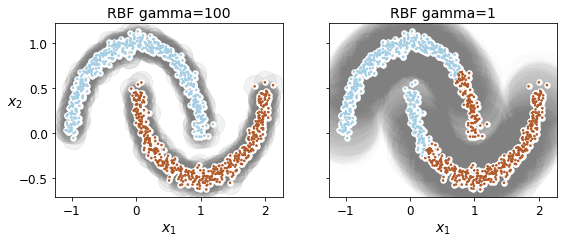

In [149]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

병합 군집

In [150]:
from sklearn.cluster import AgglomerativeClustering

In [151]:
X = np.array([0,2,5,8.5]).reshape(-1,1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [154]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
           if attrib.endswith("_") and not attrib.startswith("_")]

In [155]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [156]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## 9.2 가우시안 혼합
샘플이 파라미터가 알려지지 않은 여러 개의 혼합된 가우시안 분포에서 생성되었다고 가정하는 확률 모델\
하나의 가우시안 분포에서 생성된 모든 샘플은 하나의 클러스터를 형성한다. 일반적으로 클러스터는 타원형입니다.

In [157]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

In [158]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10)

In [159]:
gm.weights_

array([0.40004337, 0.20954915, 0.39040749])

In [160]:
gm.means_

array([[-1.40765148,  1.42718339],
       [ 3.40011393,  1.05931676],
       [ 0.0516183 ,  0.07550754]])

In [161]:
gm.covariances_

array([[[ 0.63477114,  0.72969538],
        [ 0.72969538,  1.16085164]],

       [[ 1.14631283, -0.03285453],
        [-0.03285453,  0.95505142]],

       [[ 0.68856426,  0.79633822],
        [ 0.79633822,  1.21252023]]])

알고리즘이 실제로 수렴하였나요?

In [163]:
gm.converged_

True

몇 번 반복했나요?

In [164]:
gm.n_iter_

4

In [165]:
gm.predict(X)

array([2, 2, 0, ..., 1, 1, 1], dtype=int64)

In [166]:
gm.predict_proba(X)

array([[6.73632768e-07, 2.30956994e-02, 9.76903627e-01],
       [6.72738827e-04, 1.63176388e-02, 9.83009622e-01],
       [9.99922105e-01, 1.96800317e-06, 7.59268139e-05],
       ...,
       [2.09167854e-26, 9.99999561e-01, 4.38851876e-07],
       [1.41536116e-41, 1.00000000e+00, 5.40181989e-16],
       [7.72772760e-41, 1.00000000e+00, 2.38611270e-15]])

이 모델은 생성 모델입니다. 즉 이 모델에서 새로운 샘플을 만들 수 있습니다.\
(반환된 샘플은 클러스터 인덱스 순으로 정렬되어 있습니다.)

In [167]:
X_new, y_new = gm.sample(6)

In [168]:
X_new

array([[-2.41201575,  0.16418759],
       [-0.09821204,  3.29239983],
       [-1.7827568 ,  0.96675944],
       [ 1.84826184,  2.60048933],
       [-0.17131403,  0.19359157],
       [ 1.15018001,  1.70148566]])

In [169]:
y_new

array([0, 0, 0, 1, 2, 2])

주어진 위치에서 모델의 밀도를 추정할 수 있습니다. 이를 위해 score_samples() 메서드를 이용합니다.\
샘플이 주어지면 이 메서드는 그 위치의 확률 밀도 함수의 로그를 예측합니다. 점수가 높을수록 밀도가 높습니다.

In [170]:
gm.score_samples(X)

array([-2.60806011, -3.57076496, -3.3306168 , ..., -3.51374548,
       -4.39785401, -3.80701199])

샘플이 특정 지역 안에 속할 확률을 예측하려면 그 지역에 대해 PDF를 적분해야합니다.\
가능한 샘플 위치 전 지역에 대해 적분해 더하면 1이 됩니다.

In [172]:
resolution = 100
grid = np.arange(-10,10,1 / resolution)
xx, yy = np.meshgrid(grid,grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999236657

In [173]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

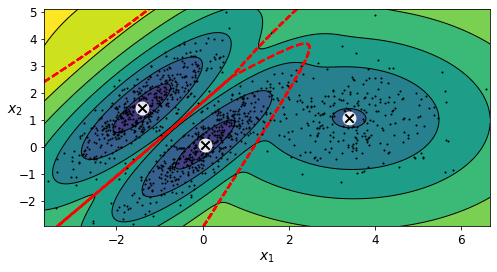

In [174]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

plt.show()

covariance_type 매개변수에 다음 값을 설정하여 제약을 추가할 수 있습니다.\
기본 값은 "full"입니다.
- "spherical" : 모든 클러스터가 원형입니다. 하지만 지름은 다를 수 있습니다.(즉, 분산이 다릅니다.)
- "diag" : 클러스터는 크기에 상관없이 어떤 타원형도 가능합니다. 하지만 타원의 축은 좌표 축과 나란해야 합니다. 즉 공분산 행렬이 대각 행렬
- "tied" : 모든 클러스터가 동일한 타원 모양, 크기, 방향을 가집니다. 즉 모든 클러스터는 동일한 공분산 행렬을 공유합니다.

In [175]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [176]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)

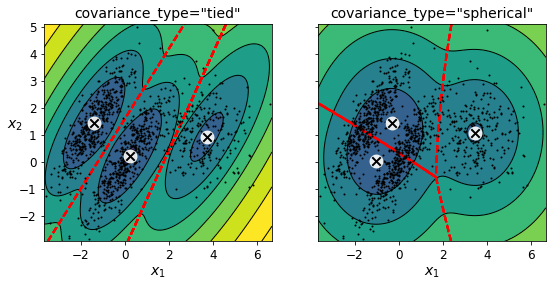

In [178]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

plt.show()

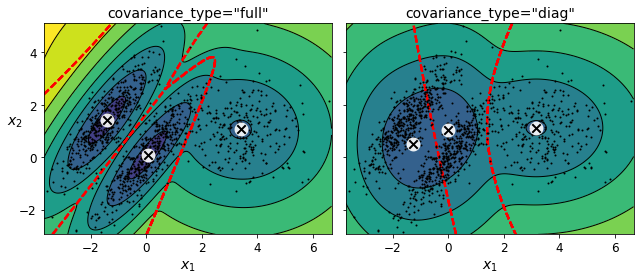

In [179]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### 9.2.1 가우시안 혼합을 사용한 이상치 탐지

In [180]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

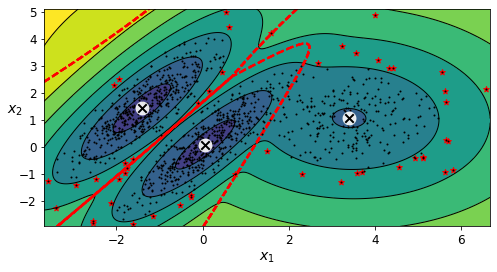

In [181]:
plt.figure(figsize=(8,4))

plot_gaussian_mixture(gm,X)
plt.scatter(anomalies[:,0], anomalies[:,1], color='r', marker='*')
plt.ylim(top=5.1)

plt.show()

### 9.2.2 클러스터 개수 선택하기

BIC(Bayesian Information Criterion)이나 AIC(Akaike Information Criterion)과 같은 이론적 정보 기준을 최소화하는 모델을 찾는다.\
BIC와 AIC 모두 모델이 많은 파라미터(예를 들면 클러스터가 많은)를 학습하지 못하도록 제한합니다. 그리고 데이터에 잘 맞는 모델(즉, 관측 데이터에 가능도가 높은 모델)에 보상을 줍니다.

In [182]:
gm.bic(X)

8189.718049665738

In [184]:
gm.aic(X)

8102.4927695507

In [185]:
# 다음과 같이 BIC를 수동으로 계산할 수 있습니다.
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [186]:
bic,aic

(8189.718049665738, 8102.4927695507)

In [187]:
n_params

17

In [188]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: User

In [189]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

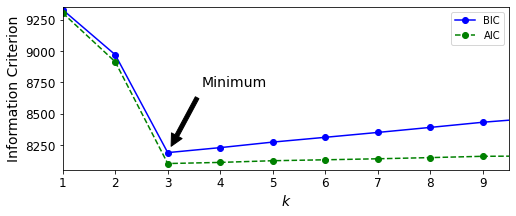

In [190]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

클러스터 개수와 covariance_type 하이퍼파라미터의 최적 조합을 찾아보자

In [191]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\sklearn\cluster\_kmeans.py:1036: User

In [192]:
best_k

3

In [193]:
best_covariance_type

'full'

가능도 함수

In [205]:
from scipy.stats import norm

In [206]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

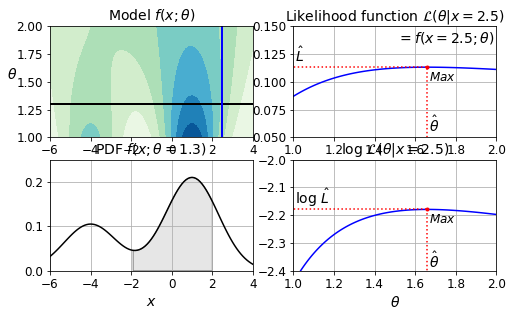

In [207]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.show()

### 9.2.3 베이즈 가우시안 혼합 모델

불필요한 클러스터의 가중치를 0으로 또는 0에 가깝게 만드는 BayesianGaussianMixture 클래스를 사용할 수 있다.\
클러스터 개수 n_components를 최적의 클러스터 개수보다 크다고 믿을 만한 값으로 지정합니다.

In [196]:
from sklearn.mixture import BayesianGaussianMixture
bgm = BayesianGaussianMixture(n_components=10, n_init=10,random_state =42)
bgm.fit(X)
np.round(bgm.weights_,2)

array([0.4 , 0.21, 0.4 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

알고리즘이 자동으로 3개의 component가 팔요하다는 것을 감지했습니다.

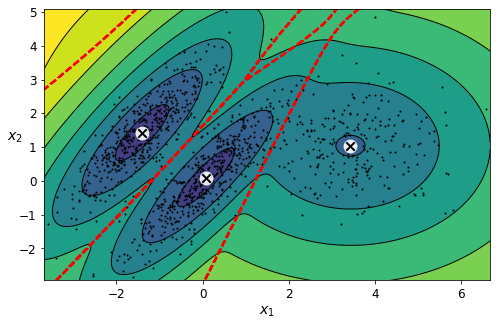

In [197]:
plt.figure(figsize=(8,5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [198]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [199]:
np.round(bgm_low.weights_, 2)

array([0.52, 0.48, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [200]:
np.round(bgm_high.weights_, 2)

array([0.01, 0.18, 0.27, 0.11, 0.01, 0.01, 0.01, 0.01, 0.37, 0.01])

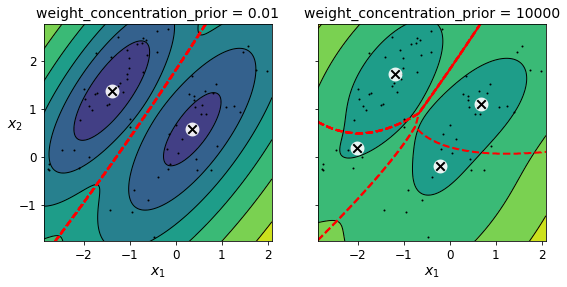

In [201]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

plt.show()

In [202]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [203]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

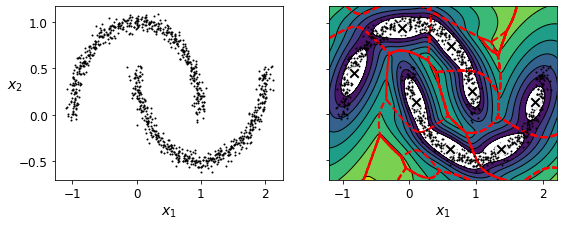

In [204]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

plt.show()

반달 모양 클러스터 2개를 감지하는 대신 이 알고리즘은 8개의 타원 클러스터를 감지했습니다. 하지만 밀도 그래프는 그렇게 나쁘지 않기에 이상치 탐지에 사용할 수 있습니다.